### Подготовим данные.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
trips19 = pd.read_csv('tripdata_2019-05.csv')

In [3]:
trips20 = pd.read_csv('tripdata_2020-05.csv')

/home/khodor/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# для того, чтобы не засорять оперативу непонятными данными, удалим их на время
del_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'congestion_surcharge']
trips19 = trips19.drop(columns=del_columns)
trips20 = trips20.drop(columns=del_columns)

Посмотрим, какие пропущенные значения есть в данных.

In [5]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
tolls_amount 0
total_amount 0


In [6]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
tolls_amount 0
total_amount 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [7]:
max_passengers_count = trips20['passenger_count'].value_counts().idxmax()
print("Max passengers count = ", max_passengers_count)
trips20.passenger_count = trips20.passenger_count.fillna(max_passengers_count)

Max passengers count =  1.0


Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

Преобразуем формат ячеек с временем для удобства.

In [8]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

In [9]:
trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца, а также те строки, в которых id районов посадки/высадки больше 263(их именно столько).

In [10]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips19 = trips19[trips19.PULocationID <= 263]

In [11]:
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]
trips20 = trips20[trips20.PULocationID <= 263]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [12]:
MILES_TO_KM = 1609.34

In [13]:
trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['trip_distance'] = trips19['trip_distance'] * MILES_TO_KM
trips19['average_velocity'] = trips19['trip_distance'] / trips19['trip_duration_secs']

In [14]:
trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['trip_distance'] = trips20['trip_distance'] * MILES_TO_KM
trips20['average_velocity'] = trips20['trip_distance'] / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 50 м/с сверху и 0.1 м/с снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [15]:
trips19 = trips19[trips19.average_velocity <= 50]
trips19 = trips19[trips19.average_velocity >= 1]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]

In [16]:
trips20 = trips20[trips20.average_velocity <= 50]
trips20 = trips20[trips20.average_velocity >= 1]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]

Посмотрим на некоторые статистики данных, которые может предоставить python.

In [17]:
trips19.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7.385731e+06,7385731,7.385731e+06,7.385731e+06
mean,1.570614e+00,4.929638e+03,1.625785e+02,1.609693e+02,1.280370e+00,1.335574e+01,4.004020e-01,1.947199e+01,1.547576e+01,2.990719e+00,1.397251e+01,1.401896e+01,0 days 00:15:03.367981,9.033563e+02,5.019484e+00
std,1.220758e+00,6.347936e+03,6.578341e+01,6.993166e+01,4.641845e-01,1.179477e+01,1.765512e+00,1.462736e+01,8.934218e+00,1.843606e+00,6.000676e+00,6.091107e+00,0 days 00:12:33.803511,7.528011e+02,2.748132e+00
min,0.000000e+00,1.609340e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:01,1.000000e+00,1.000050e+00
25%,1.000000e+00,1.609340e+03,1.140000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,1.130000e+01,8.000000e+00,2.000000e+00,1.000000e+01,1.000000e+01,0 days 00:06:54,4.140000e+02,3.218680e+00
50%,1.000000e+00,2.703691e+03,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,1.480000e+01,1.500000e+01,3.000000e+00,1.500000e+01,1.500000e+01,0 days 00:11:32,6.920000e+02,4.371722e+00
75%,2.000000e+00,4.988954e+03,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,0.000000e+00,2.080000e+01,2.300000e+01,4.000000e+00,1.900000e+01,1.900000e+01,0 days 00:18:59,1.139000e+03,5.998449e+00
max,9.000000e+00,4.235944e+05,2.630000e+02,2.650000e+02,4.000000e+00,4.016500e+03,9.210600e+02,4.020300e+03,3.100000e+01,6.000000e+00,2.300000e+01,2.300000e+01,1 days 06:10:50,5.225000e+04,4.997424e+01


In [18]:
trips20.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,332655.000000,332655.000000,332655.000000,332655.000000,275549.000000,332655.000000,332655.000000,332655.000000,332655.000000,332655.000000,332655.000000,332655.000000,332655,332655.000000,332655.000000
mean,1.267382,6136.953543,151.948187,148.050635,1.412036,13.589841,0.435284,18.423455,16.364630,3.002609,13.109711,13.161882,0 days 00:11:55.328845,715.328845,7.492734
std,0.914834,7613.067198,70.246987,74.466698,0.530211,12.905031,1.897605,14.351808,8.827788,1.876784,5.306728,5.345274,0 days 00:10:12.111832,612.111832,3.396876
min,0.000000,16.093400,1.000000,1.000000,1.000000,-10.860000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0 days 00:00:02,2.000000,1.002357
25%,1.000000,1770.274000,90.000000,75.000000,1.000000,6.000000,0.000000,10.300000,9.000000,1.000000,9.000000,9.000000,0 days 00:05:15,315.000000,5.176710
50%,1.000000,3331.333800,142.000000,143.000000,1.000000,9.000000,0.000000,13.800000,16.000000,3.000000,14.000000,14.000000,0 days 00:08:58,538.000000,6.654002
75%,1.000000,7081.096000,230.000000,230.000000,2.000000,15.790000,0.000000,20.800000,24.000000,4.000000,17.000000,17.000000,0 days 00:15:25,925.000000,8.885510
max,6.000000,491009.634000,263.000000,265.000000,4.000000,819.500000,200.000000,1042.820000,31.000000,6.000000,23.000000,23.000000,0 days 11:56:00,42960.000000,49.970820


### Получим представление о районах Нью-Йорка.

В Нью-Йорке есть 5 основных районов: Manhattan, Queens, Brooklyn, Staten Island и Bronx.

![ny_map](pictures/ny_map.jpg)

Manhattan является главным туристическим местом, а также скоплением главных бизнес-центров Нью-Йорка. Тут очень развита инфраструктура  (не)активного времяпрепровождения.

Queens является одним из наиболее "спальных" районов города. Однако тут расположен Национальный аэропорт имени Джона Кеннеди - аэропорт с самым большим трафиком пассажирских и грузовых авиаперевозок в мире, что в купе с тем фактом, что тут происходит множество спортивных мероприятий, добавляет посещаемости приезжими.

Brooklyn - самый населённый район Нью-Йорка. При этом тут очень развита инфраструктура локальных мероприятий, что позволяет жителям не ездить куда-то, а "жить на месте".

В Bronx'е находится печально известный своей неблагополучностью квартал Camp Apache. Однако сейчас там всё спокойно. Более того, среди туристов имеют популярность несколько иностранных кварталов

Staten Island - самый тихий район с наименьшей численностью населения. Туристов сюда не тянет в силу того, что тут "почти не на что смотреть". Однако с его замечательной природой можно отдохнуть от суеты других районов.

### Визуализируем данные.

In [20]:
# зададим размер графиков
plt.rcParams['figure.dpi'] = 90

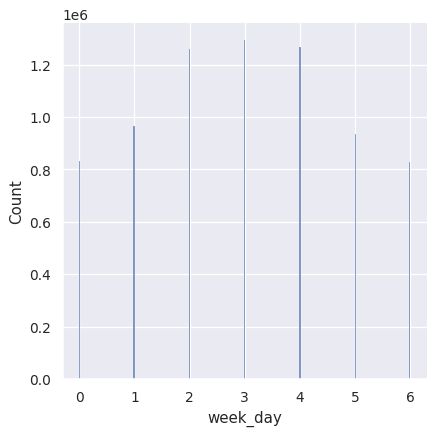

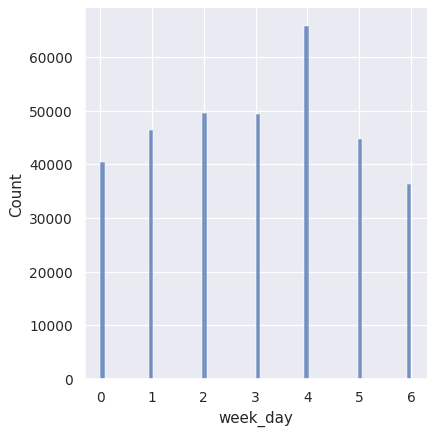

In [21]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

Выше видим выброс в пятницу в 2020м году. Возможно это объясняется режимом самоизоляции, который очень хочется нарушить в конце рабочей недели(либо в целом возвращение с работы домой, если это не является ежедневной рутиной).

В противоложность этому основная нагрузка в 19м году приходится на середину рабочей недели. # (хм, почему?)

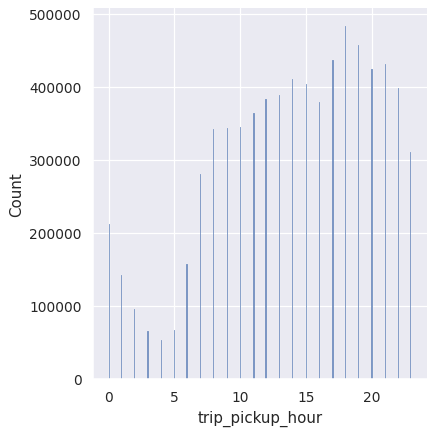

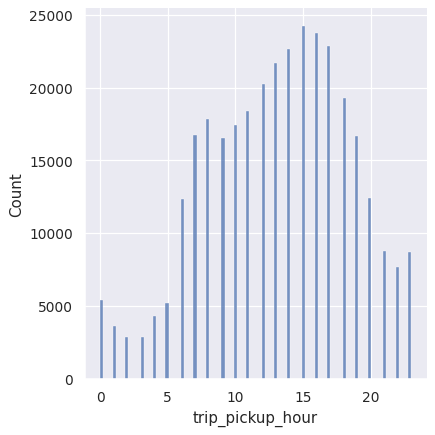

In [22]:
sns.displot(trips19.trip_pickup_hour)
sns.displot(trips20.trip_pickup_hour)

В 19 году видим основную нагрузку на 6-7 часов вечера, т.к. жители возвращаются с работы попутно заезжая по делам.

Однако в 20м году пик приходится на 3 часа дня. Возможно это потому что весь город подумал, что днём будет мало людей на улицах из-за работы и побежал делать свои дела.

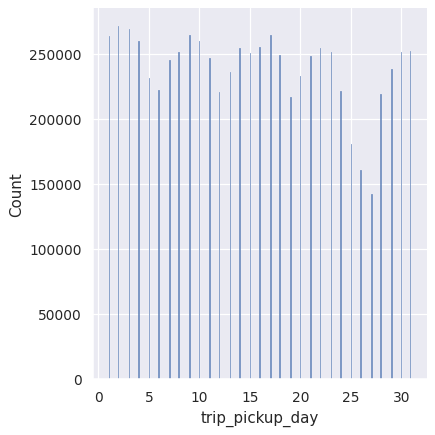

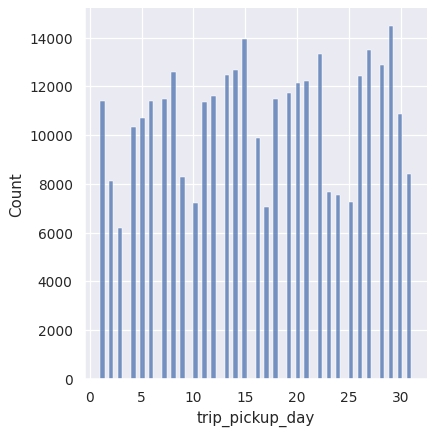

In [23]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

В оба года видим снижения использования средств передвижение во время выходных. Однако в 19м году имеется тенденция к постепенному снижению использования такси в течение рабочих дней(люди начинают готовится к отпуску и собственно отдыхать), тогда как в 20м году правило обратно: использование повышается, - тут это обуславливается тем, что люди уже устали сидеть некоторое время на карантине и начинают "подзабивать" на рекомендации самоизоляции.

Также отметим резкое(даже относительно выходных) снижение поездок 27.05.2019 и 25.05.2020, т.к. в этот день федеральный праздник День Памяти, являющийся выходным.

(0.0, 5000.0)

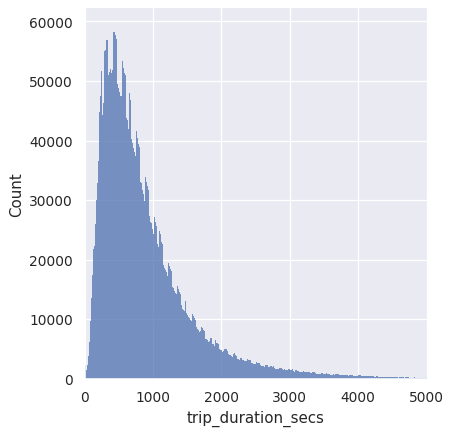

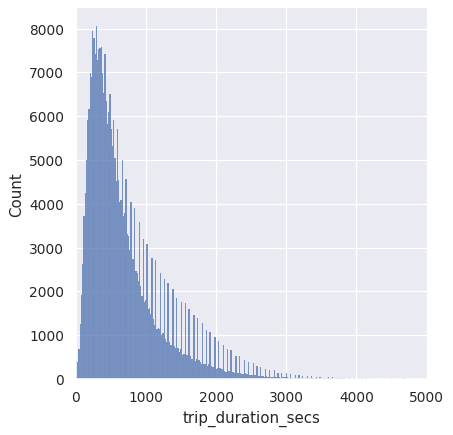

In [24]:
sns.displot(trips19, x='trip_duration_secs')
plt.xlim(0, 5000)
sns.displot(trips20, x='trip_duration_secs')
plt.xlim(0, 5000)

Похоже на распределение Пуассона или Максвелла.

На 2м графике существуют видимые выбросы, но это скорее из-за малого количества наблюдений. На 1м графике тенденция видна гораздо лучше и без выбросов.

Легко увидеть, что пользователи совершают очень много коротких поездок(до 30 минут) и очень мало длинных(более часа). На ум приходят две причины: немалая стоимость длинной поездки + средний пассажир(на мой взгляд) ездит ради скорости  и независимости от большинства других факторов(расписание общественного транспорта, движение от точки до точки).

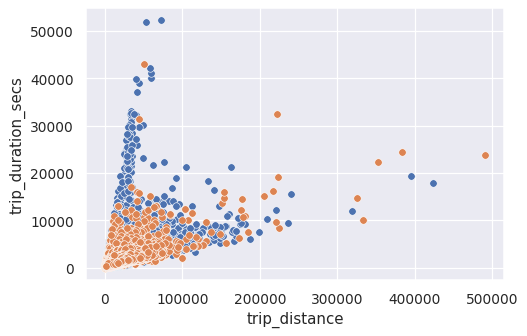

In [25]:
sns.scatterplot(data=trips19, x=trips19['trip_distance'], y=trips19['trip_duration_secs'])
sns.scatterplot(data=trips20, x=trips20['trip_distance'], y=trips20['trip_duration_secs'])

По графикам зависимости времени поездки от расстояния можем понять, что в целом они распределены примерно одинаково относительно друг друга(в целом этому виной например то, как мы убирали выбросы), т.е. эпидемия повлияла в данном случае только на количество поездок и уменьшение числа длительных поездок.

Однако есть очень много поездок с короткими дистанциями, но значительным временем. Это может объясняться большим трафиком в загруженные части дня. Как видим, систематически такой проблемы в 20м году не наблюдалось в силу того, что в целом загруженность узлов была меньше $\implies$ меньше пробок.

(0.0, 25.0)

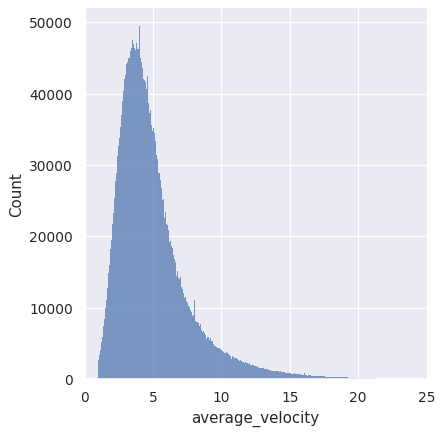

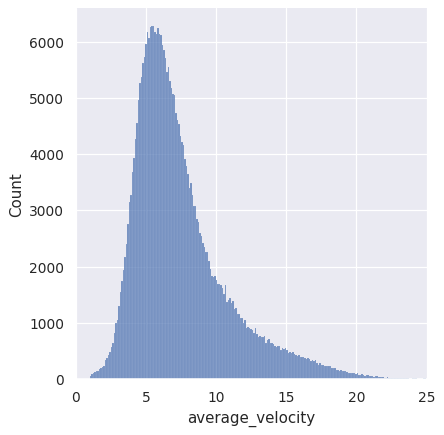

In [26]:
sns.displot(trips19, x='average_velocity')
plt.xlim(0, 25)
sns.displot(trips20, x='average_velocity')
plt.xlim(0, 25)

Видим уже знакомое распределение. Пики расположены около средних скоростей, которые составляют соответственно 18 и 27 км/ч, что вполне нормально для Нью-Йорка с его трафиком и пробками. Для передвижения со скоростью выше 48 км/ч(13.3 м/с) требуется либо быть каким-нибудь служебным автомобилем(скорая, полиция или пожарные), либо нарушать скоростной режим(чем, видимо, не пренебрегает некоторое количество водителей).

![19fool](pictures/19.jpg)
![20fool](pictures/20.jpg)

Кажется, за весь период мы ничего конкретного не вынесем. Особенно из прошлого года. Однако в этом году можно заметить, что популярным осталось направления Manhatten(и собственно весь он сам) и 2 аэропорта в Queens, а также в 19м году аэропорт Ньюарк. Однако можем заметить, что и так малое количество поездок из Staten Island стало ещё меньше(возможно потому что там много русских, а раз Президент сказал самоизолироваться, нужно самоизолироваться).

![19weekday](pictures/19weekday.jpg)
![19weekend](pictures/19weekend.jpg)

Здесь отображены поездки за рабочие дни и за выходные в мае 19ого года. 

На выходных видим значительное уменьшение поездок в район Staten Island. Это, возможно, обусловлено тем, что много жителей едут в другие районы на работу, а вся инфраструктура для отдыха на выходных присутствует на месте. Более того, вспоминая, что этот район является довольно тихим, можно сделать вывод, что жители не хотят суеты ещё и в выходные.

Также можно заметить небольшое уменьшение трафика из аэропортов на выходных(вероятно потому Нью-Йорк популярный город даже больше для рабочих визитов, чем для отдыха).

Однако в целом плотность в центральных районах не изменилась.

![20weelday](pictures/20weekday.jpg)
![20weekend](pictures/20weekend.jpg)

В противоположность этому на выходных 20ого видно значительное снижение использования такси. Популярным остались Manhattan и аэропорты, но очевидно снижение переездов между дальними частями города. Также можем заметить, что из аэропорта Ньюарк почти полностью перестали ездить.

В целом можно понять, что Manhattan всегда имел большой трафик из-за множества туристов и большого количества бизнес-центров.